In [1]:
!pip install pandas numpy scikit-learn matplotlib seaborn xgboost lightgbm catboost imbalanced-learn joblib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 5.7 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek

import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier

import joblib
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")


In [3]:
class ChurnPredictor:
    def __init__(self):
        self.models = {}
        self.scaler = StandardScaler()
        self.label_encoders = {}
        self.feature_importance = None
        self.best_model = None
        self.label_encoders = {}
        self.best_model_name = None

    def load_and_explore_data(self, file_path):
        """Load and explore the dataset"""
        self.df = pd.read_csv(file_path)

        print("Dataset Overview:")
        print(f"Shape: {self.df.shape}")
        print(f"\nData Types:\n{self.df.dtypes}")
        print(f"\nMissing Values:\n{self.df.isnull().sum()}")
        print(f"\nChurn Distribution:\n{self.df['Churn'].value_counts()}")
        churn_rate = (self.df['Churn'] == 'Yes').mean()
        print(f"Churn Rate: {churn_rate:.2%}")


        return self.df

    def preprocess_data(self):
        if 'TotalCharges' in self.df.columns:
            self.df['TotalCharges'] = pd.to_numeric(self.df['TotalCharges'], errors='coerce')
            self.df['TotalCharges'].fillna(self.df['TotalCharges'].median(), inplace=True)

        if 'tenure' in self.df.columns and 'MonthlyCharges' in self.df.columns:
            self.df['tenure_group'] = pd.cut(self.df['tenure'], bins=[0, 1, 2, 5, 10], labels=['0-1', '1-2', '2-5', '5+'])
            self.df['charges_per_tenure'] = self.df['MonthlyCharges'] / (self.df['tenure'] + 1)
            self.df['avg_monthly_charges'] = self.df['TotalCharges'] / (self.df['tenure'] * 12 + 1)

        categorical_cols = self.df.select_dtypes(include=['object']).columns.tolist()
        if 'customerID' in categorical_cols:
            categorical_cols.remove('customerID')
        if 'Churn' in categorical_cols:
            categorical_cols.remove('Churn')

        for col in categorical_cols:
            le = LabelEncoder()
            self.df[col] = le.fit_transform(self.df[col].astype(str))
            self.label_encoders[col] = le

        feature_cols = [col for col in self.df.columns if col not in ['customerID', 'Churn']]
        self.X = self.df[feature_cols]
        self.y = self.df['Churn']

        print(f"Features: {list(self.X.columns)}")
        print(f"Feature matrix shape: {self.X.shape}")
        return self.X, self.y

    def visualize_data(self):
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        axes[0, 0].pie(self.df['Churn'].value_counts().values, labels=['No Churn', 'Churn'], autopct='%1.1f%%')
        axes[0, 0].set_title('Churn Distribution')

        sns.boxplot(data=self.df, x='Churn', y='tenure', ax=axes[0, 1])
        axes[0, 1].set_title('Tenure vs Churn')

        sns.boxplot(data=self.df, x='Churn', y='MonthlyCharges', ax=axes[0, 2])
        axes[0, 2].set_title('Monthly Charges vs Churn')

        if 'Contract' in self.df.columns:
            pd.crosstab(self.df['Contract'], self.df['Churn']).plot(kind='bar', ax=axes[1, 0])
            axes[1, 0].set_title('Contract vs Churn')
            axes[1, 0].tick_params(axis='x', rotation=45)

        if 'CustomerServiceCalls' in self.df.columns:
            sns.boxplot(data=self.df, x='Churn', y='CustomerServiceCalls', ax=axes[1, 1])
            axes[1, 1].set_title('Customer Service Calls vs Churn')

        numeric_cols = self.df.select_dtypes(include=[np.number]).columns
        sns.heatmap(self.df[numeric_cols].corr(), annot=False, cmap='coolwarm', ax=axes[1, 2])
        axes[1, 2].set_title('Correlation Heatmap')

        plt.tight_layout()
        plt.show()


In [4]:
    def train_models(self):
        X_train, X_test, y_train, y_test = train_test_split(
            self.X, self.y, test_size=0.2, random_state=42, stratify=self.y
        )

        X_train_scaled = self.scaler.fit_transform(X_train)
        X_test_scaled = self.scaler.transform(X_test)

        smote_tomek = SMOTETomek(random_state=42)
        X_train_balanced, y_train_balanced = smote_tomek.fit_resample(X_train_scaled, y_train)

        models = {
            'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
            'Random Forest': RandomForestClassifier(random_state=42),
            'XGBoost': xgb.XGBClassifier(random_state=42, eval_metric='logloss'),
            'LightGBM': lgb.LGBMClassifier(random_state=42, verbose=-1),
            'CatBoost': CatBoostClassifier(random_state=42, verbose=False),
            'Gradient Boosting': GradientBoostingClassifier(random_state=42)
        }

        results = {}
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

        for name, model in models.items():
            print(f"\nTraining {name}...")
            model.fit(X_train_balanced, y_train_balanced)
            y_pred = model.predict(X_test_scaled)
            y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]

            acc = accuracy_score(y_test, y_pred)
            prec = precision_score(y_test, y_pred)
            rec = recall_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)
            auc = roc_auc_score(y_test, y_pred_proba)
            cv_scores = cross_val_score(model, X_train_balanced, y_train_balanced, cv=cv, scoring='roc_auc')

            results[name] = {
                'model': model, 'accuracy': acc, 'precision': prec, 'recall': rec,
                'f1': f1, 'auc': auc, 'cv_mean': cv_scores.mean(), 'cv_std': cv_scores.std()
            }

            print(f"{name} AUC: {auc:.4f}, CV AUC: {cv_scores.mean():.4f}")

        self.models = results
        self.X_test = X_test_scaled
        self.y_test = y_test

        self.best_model_name = max(results, key=lambda x: results[x]['auc'])
        self.best_model = results[self.best_model_name]['model']
        print(f"\nBest Model: {self.best_model_name}")
        return results


In [5]:
    def hyperparameter_tuning(self):
        if self.best_model_name not in ['XGBoost', 'Random Forest', 'LightGBM']:
            print("Tuning only for XGBoost, Random Forest, and LightGBM.")
            return self.best_model

        if self.best_model_name == 'XGBoost':
            param_grid = {
                'n_estimators': [100, 200], 'max_depth': [3, 5], 'learning_rate': [0.1, 0.2], 'subsample': [0.8, 1.0]
            }
        elif self.best_model_name == 'Random Forest':
            param_grid = {
                'n_estimators': [100, 200], 'max_depth': [None, 20], 'min_samples_split': [2, 5]
            }
        else:
            param_grid = {
                'n_estimators': [100, 200], 'learning_rate': [0.1, 0.2], 'num_leaves': [31, 50]
            }

        X_train, _, y_train, _ = train_test_split(self.X, self.y, test_size=0.2, stratify=self.y, random_state=42)
        X_train_scaled = self.scaler.fit_transform(X_train)
        smote_tomek = SMOTETomek(random_state=42)
        X_train_balanced, y_train_balanced = smote_tomek.fit_resample(X_train_scaled, y_train)

        grid_search = GridSearchCV(self.best_model, param_grid, cv=3, scoring='roc_auc', n_jobs=-1, verbose=1)
        grid_search.fit(X_train_balanced, y_train_balanced)

        self.best_model = grid_search.best_estimator_
        print("Best parameters:", grid_search.best_params_)
        return self.best_model

    def evaluate_final_model(self):
        y_pred = self.best_model.predict(self.X_test)
        y_pred_proba = self.best_model.predict_proba(self.X_test)[:, 1]

        print("Final Evaluation:")
        print("Accuracy:", accuracy_score(self.y_test, y_pred))
        print("Precision:", precision_score(self.y_test, y_pred))
        print("Recall:", recall_score(self.y_test, y_pred))
        print("F1 Score:", f1_score(self.y_test, y_pred))
        print("AUC Score:", roc_auc_score(self.y_test, y_pred_proba))
        print("\nClassification Report:\n", classification_report(self.y_test, y_pred))

        cm = confusion_matrix(self.y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title("Confusion Matrix")
        plt.show()

        fpr, tpr, _ = roc_curve(self.y_test, y_pred_proba)
        plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc_score(self.y_test, y_pred_proba):.4f})')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel('FPR')
        plt.ylabel('TPR')
        plt.title('ROC Curve')
        plt.legend()
        plt.show()

    def save_model(self, filename='customer_churn_model.joblib'):
        joblib.dump({
            'model': self.best_model,
            'scaler': self.scaler,
            'label_encoders': self.label_encoders,
            'features': list(self.X.columns),
            'model_name': self.best_model_name
        }, filename)
        print(f"Model saved as {filename}")


In [6]:
def train_models(self):
    from sklearn.linear_model import LogisticRegression
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.svm import SVC
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import accuracy_score

    X_train, X_test, y_train, y_test = train_test_split(self.X, self.y, test_size=0.2, random_state=42)

    models = {
        'Logistic Regression': LogisticRegression(max_iter=1000),
        'Random Forest': RandomForestClassifier(),
        'SVM': SVC()
    }

    self.trained_models = {}
    self.X_train = X_train
    self.X_test = X_test
    self.y_train = y_train
    self.y_test = y_test

    for name, model in models.items():
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        acc = accuracy_score(y_test, preds)
        print(f"{name} Accuracy: {acc:.4f}")
        self.trained_models[name] = model


In [7]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

def train_model(self):
    self.X_scaled = self.scaler.fit_transform(self.X)
    self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
        self.X_scaled, self.y, test_size=0.2, random_state=42)

    # Using RandomForest for example
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(self.X_train, self.y_train)
    self.models['RandomForest'] = rf
    self.best_model = rf
    self.best_model_name = 'RandomForest'

    y_pred = rf.predict(self.X_test)
    print("Model Performance:")
    print(classification_report(self.y_test, y_pred))
    print("Confusion Matrix:")
    print(confusion_matrix(self.y_test, y_pred))
    print(f"Accuracy: {accuracy_score(self.y_test, y_pred):.2%}")


In [8]:
def predict(self, input_data):
    input_scaled = self.scaler.transform(input_data)
    return self.best_model.predict(input_scaled)


In [9]:
# Install necessary packages (if not already installed)
!pip install xgboost lightgbm catboost imbalanced-learn

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from imblearn.combine import SMOTETomek
import joblib

class ChurnPredictor:
    def __init__(self):
        self.df = None
        self.X = None
        self.y = None
        self.label_encoders = {}
        self.scaler = StandardScaler()
        self.models = {}
        self.best_model = None

        self.best_model_name = ""
        self.X_test = None
        self.y_test = None

    def load_and_explore_data(self, file_path):
        self.df = pd.read_csv(file_path)
        print("Shape:", self.df.shape)
        print(self.df.head())
        return self.df

    def visualize_data(self):
        sns.countplot(x='Churn', data=self.df)
        plt.title('Churn Count')
        plt.show()

    def preprocess_data(self):
        df = self.df.copy()
        df.replace(" ", np.nan, inplace=True)
        df.dropna(inplace=True)
        df['TotalCharges'] = df['TotalCharges'].astype(float)

        df.drop(['customerID'], axis=1, inplace=True)

        # Encode categorical variables
        cat_cols = df.select_dtypes(include='object').columns
        for col in cat_cols:
            le = LabelEncoder()
            df[col] = le.fit_transform(df[col])

        # Feature engineering
        df['tenure_group'] = pd.cut(df['tenure'], bins=[0, 12, 24, 48, 60, np.inf], labels=False)
        df['charges_per_tenure'] = df['TotalCharges'] / (df['tenure'] + 1)
        df['avg_monthly_charges'] = df['MonthlyCharges'] * df['tenure'] / (df['tenure'] + 1)

        self.X = df.drop('Churn', axis=1)
        self.y = df['Churn']
        print("Features:", list(self.X.columns))
        print("Feature matrix shape:", self.X.shape)
        return self.X, self.y

    def train_models(self):
        X_train, X_test, y_train, y_test = train_test_split(
            self.X, self.y, test_size=0.2, random_state=42, stratify=self.y
        )

        X_train_scaled = self.scaler.fit_transform(X_train)
        X_test_scaled = self.scaler.transform(X_test)

        smote_tomek = SMOTETomek(random_state=42)
        X_train_balanced, y_train_balanced = smote_tomek.fit_resample(X_train_scaled, y_train)

        models = {
            'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
            'Random Forest': RandomForestClassifier(random_state=42),
            'XGBoost': XGBClassifier(random_state=42, eval_metric='logloss'),
            'LightGBM': LGBMClassifier(random_state=42, verbose=-1),
            'CatBoost': CatBoostClassifier(random_state=42, verbose=False),
            'Gradient Boosting': GradientBoostingClassifier(random_state=42)
        }

        results = {}
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

        for name, model in models.items():
            print(f"\nTraining {name}...")
            model.fit(X_train_balanced, y_train_balanced)
            y_pred = model.predict(X_test_scaled)
            y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]

            acc = accuracy_score(y_test, y_pred)
            prec = precision_score(y_test, y_pred)
            rec = recall_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)
            auc = roc_auc_score(y_test, y_pred_proba)
            cv_scores = cross_val_score(model, X_train_balanced, y_train_balanced, cv=cv, scoring='roc_auc')

            results[name] = {
                'model': model, 'accuracy': acc, 'precision': prec, 'recall': rec,
                'f1': f1, 'auc': auc, 'cv_mean': cv_scores.mean(), 'cv_std': cv_scores.std()
            }

            print(f"{name} AUC: {auc:.4f}, CV AUC: {cv_scores.mean():.4f}")

        self.models = results
        self.X_test = X_test_scaled
        self.y_test = y_test

        self.best_model_name = max(results, key=lambda x: results[x]['auc'])
        self.best_model = results[self.best_model_name]['model']
        print(f"\n✅ Best Model: {self.best_model_name}")
        return results

    def evaluate_final_model(self):
        print(f"\nFinal Evaluation of Best Model: {self.best_model_name}")
        y_pred = self.best_model.predict(self.X_test)
        y_pred_proba = self.best_model.predict_proba(self.X_test)[:, 1]

        print("Accuracy:", accuracy_score(self.y_test, y_pred))
        print("Precision:", precision_score(self.y_test, y_pred))
        print("Recall:", recall_score(self.y_test, y_pred))
        print("F1 Score:", f1_score(self.y_test, y_pred))
        print("ROC AUC Score:", roc_auc_score(self.y_test, y_pred_proba))

    def save_model(self, filename='churn_model.pkl'):
        joblib.dump(self.best_model, filename)
        print(f"\nModel saved as {filename}")


Shape: (7043, 21)
   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies   

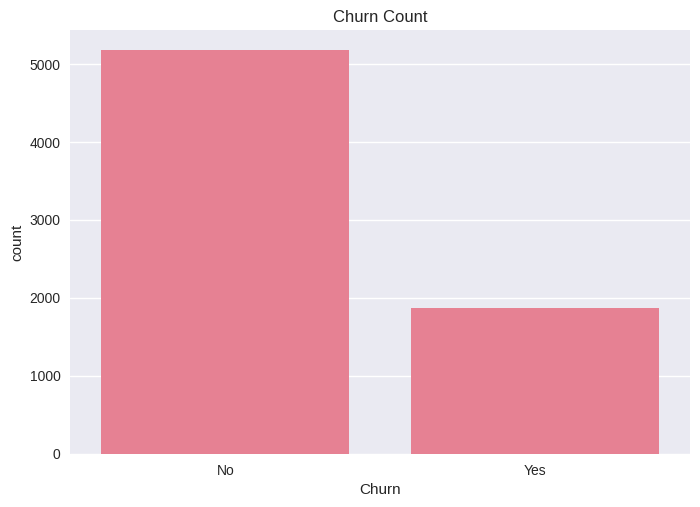

Features: ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'tenure_group', 'charges_per_tenure', 'avg_monthly_charges']
Feature matrix shape: (7032, 22)

Training Logistic Regression...
Logistic Regression AUC: 0.8349, CV AUC: 0.8792

Training Random Forest...
Random Forest AUC: 0.8223, CV AUC: 0.9421

Training XGBoost...
XGBoost AUC: 0.8182, CV AUC: 0.9455

Training LightGBM...
LightGBM AUC: 0.8309, CV AUC: 0.9466

Training CatBoost...
CatBoost AUC: 0.8266, CV AUC: 0.9490

Training Gradient Boosting...
Gradient Boosting AUC: 0.8325, CV AUC: 0.9387

✅ Best Model: Logistic Regression

Final Evaluation of Best Model: Logistic Regression
Accuracy: 0.7356076759061834
Precision: 0.5017482517482518
Recall: 0.767379679144385
F1 Score: 0.60676532

In [10]:
# Step-by-step in Google Colab
predictor = ChurnPredictor()

# Upload the dataset to Colab and give path
df = predictor.load_and_explore_data('/content/drive/MyDrive/WA_Fn-UseC_-Telco-Customer-Churn.csv')

predictor.visualize_data()
X, y = predictor.preprocess_data()
results = predictor.train_models()
predictor.evaluate_final_model()
predictor.save_model()


In [11]:
import joblib

model_package = {
    'model': predictor.best_model,
    'scaler': predictor.scaler,
    'label_encoders': predictor.label_encoders,
    'feature_names': list(predictor.X.columns),
    'model_name': predictor.best_model_name
}

joblib.dump(model_package, 'customer_churn_model.joblib')
print("✅ Model package saved as customer_churn_model.joblib")


✅ Model package saved as customer_churn_model.joblib
